In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import json
import random
import re
import os

from pyannote.audio.pipelines import VoiceActivityDetection

import analysis_utils as aute

The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.


In [2]:
config_json = open("../LableniBotConfig/config.json")
config_dict = json.load(config_json)

hugging_face_key = config_dict["HUGGING_FACE"]

silence_detection_pipeline = VoiceActivityDetection(segmentation="pyannote/segmentation",
                                                    use_auth_token=hugging_face_key)

In [3]:
all_files_conv_list = []

path_conv = "../Conversations/"
for conv_id in os.listdir(path_conv):
    if "User" in conv_id:
        path_to_csv = path_conv + conv_id + "/"
        for sub_conv_id in os.listdir(path_to_csv):
            if "User" in sub_conv_id:
                all_files_conv_list.append(path_to_csv + sub_conv_id + "/")

In [7]:
time_diff_list = []

for whole_path in all_files_conv_list:
    name_csv_file = [f for f in os.listdir(whole_path) if ".csv" in f][0]
    data = pd.read_csv(whole_path + name_csv_file, sep=";")

    p_start = data["PersonTalkStartUnix"].dropna().values
    b_end = data["BotTalkEndUnix"].dropna().values

    max_shape = np.min([p_start.shape[0], b_end.shape[0]])

    time_diff  = p_start[:max_shape] - b_end[:max_shape]

    for t in time_diff:
        if not np.isnan(t):
            time_diff_list.append(t)

Mean Elapsed time between Bot ends and person starts = 0.0021 +/- 0.0004 ; Median = 0.002 ; Min. =  0.001 ; Max. =  0.004


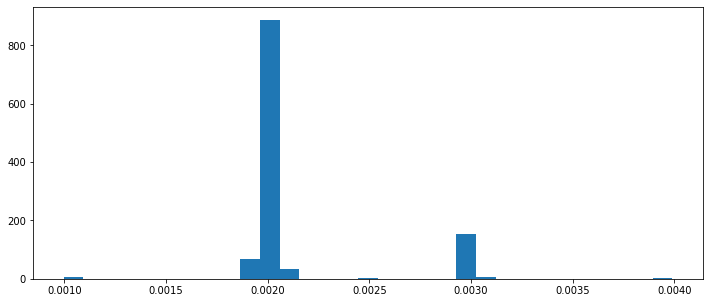

In [8]:
aute.stat_print(time_diff_list, "Elapsed time between Bot ends and person starts")

plt.figure(figsize=(12, 5))
plt.hist(time_diff_list, bins=31)

plt.show()

In [41]:
save_data_list = []

for i_wp, whole_path in enumerate(all_files_conv_list):
    
    print("Iteration", i_wp, end="\r")
    
    name_csv_file = [f for f in os.listdir(whole_path) if ".csv" in f][0]
    data = pd.read_csv(whole_path + name_csv_file, sep=";")

    path_to_audios = whole_path + "Audios/"
    all_audios = os.listdir(path_to_audios)
    for i_audio, audio in enumerate(all_audios):
        try:
            vad = silence_detection_pipeline(path_to_audios + audio)
        except:
            continue
        
        x = vad.get_timeline().segments_set_
        start_person_talk_since_audio = list(x)[0].start if len(x) > 0 else 0

        conv_position = int(audio.split(".")[0][-1])

        bot_end_talk = data["BotTalkEndUnix"].iloc[2*conv_position]
        
        if 2*conv_position+1 < data.shape[0]:
        
            person_start_talk = data["PersonTalkStartUnix"].iloc[2*conv_position+1]

            diff_listen_talk = person_start_talk + start_person_talk_since_audio - bot_end_talk

            config_name_bot = data["ConfigName"].iloc[0]
            bot_personality, bot_gender, bot_type_id = config_name_bot.split("_")
            
            bot_gender = "Female" if bot_gender=="Woman" else bot_gender
            bot_gender = "Male" if bot_gender=="Man" else bot_gender
            
            save_data_list.append({
                "PathId": i_wp,
                "ConvStartTime": data["UnixTimestampLoopInit"].iloc[0],
                "SubjectId": data["SubjectId"].iloc[0],
                "ConvStepId": i_audio,
                "DiffTimeListenTalk": diff_listen_talk,
                "AudioDetection": start_person_talk_since_audio,
                "BotPersonality": bot_personality,
                "BotGender": bot_gender,
                "BotTypeId": bot_type_id
            })
            
df_res = pd.DataFrame(save_data_list)

Mean Time thinking = 1.3713 +/- 1.7193 ; Median = 0.9723 ; Min. =  0.0019 ; Max. =  17.2229


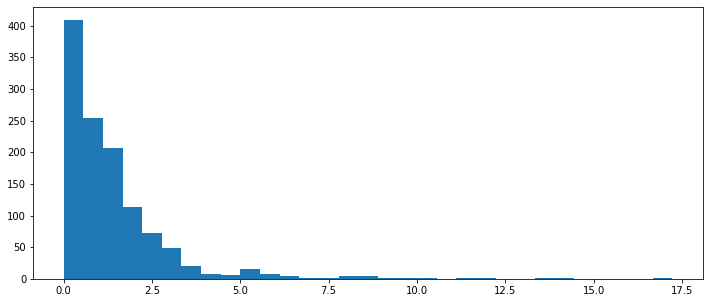

In [42]:
aute.stat_print(df_res["DiffTimeListenTalk"], "Time thinking")

plt.figure(figsize=(12, 5))
plt.hist(df_res["DiffTimeListenTalk"], bins=31)

plt.show()

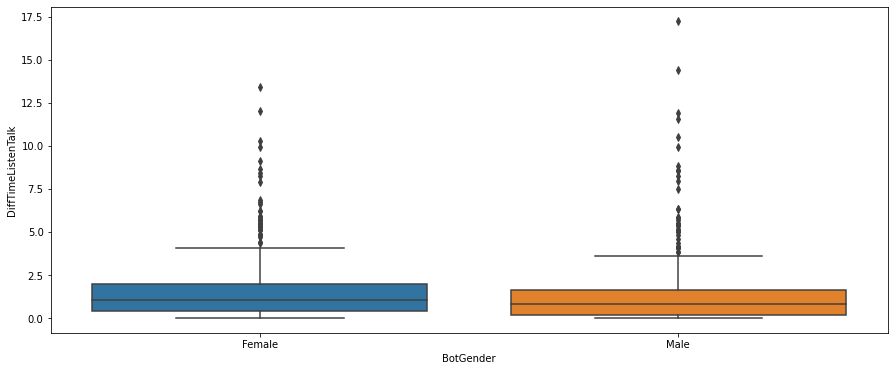

In [43]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_res, x="BotGender", y="DiffTimeListenTalk")
plt.show()

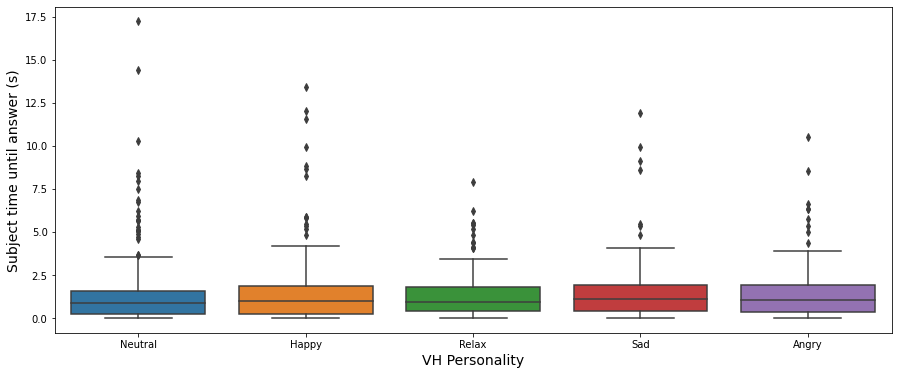

Mean Personality Angry = 1.4619 +/- 1.6281 ; Median = 1.0567 ; Min. =  0.002 ; Max. =  10.5404
Mean Personality Happy = 1.5103 +/- 2.0666 ; Median = 1.0051 ; Min. =  0.002 ; Max. =  13.4429
Mean Personality Neutral = 1.2846 +/- 1.7542 ; Median = 0.8711 ; Min. =  0.002 ; Max. =  17.2229
Mean Personality Relax = 1.2675 +/- 1.2903 ; Median = 0.947 ; Min. =  0.0019 ; Max. =  7.9248
Mean Personality Sad = 1.4642 +/- 1.7101 ; Median = 1.1242 ; Min. =  0.002 ; Max. =  11.9242


In [45]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_res, x="BotPersonality", y="DiffTimeListenTalk")
plt.ylabel("Subject time until answer (s)", fontsize=14)
plt.xlabel("VH Personality", fontsize=14)

plt.savefig("Results/Images/TimeThinking.pdf", dpi=300, format="pdf")

plt.show()

for k, df_k in df_res.groupby("BotPersonality"):
    aute.stat_print(df_k["DiffTimeListenTalk"], "Personality " + k)